In [1]:
# Load data from training data directory, convert from NPZ to tensor, and save to a dict
# containing lift name and tensor data

import os
import torch
import numpy as np
import functions
import matplotlib.pyplot as plt

DEADLIFT_TENSORS = {}
BENCH_TENSORS = {}
SQUAT_TENSORS = {}

# Setup paths
script_dir = os.path.dirname(os.path.abspath("model_train.ipynb"))
data_dir = os.path.normpath(os.path.join(script_dir, '..', 'lift data'))

# Step 1: Get all subfolder names in data_dir
subfolders = []
for f in os.listdir(data_dir):
    if os.path.isdir(os.path.join(data_dir, f)):
        subfolders.append(f)


#  Squat Files
#  Bench Files
#  Deadlift Files
for subfolder in subfolders:
    subfolder_path = os.path.join(data_dir, subfolder)
    files = []

    # Isolate individual lift files in each of the subfolders and add them to files list
    for f in os.listdir(subfolder_path):
        if os.path.isfile(os.path.join(subfolder_path, f)):
            files.append(f)

    # Iterate through files in each subfolder
    for file in files:
        data = np.load(os.path.join(subfolder_path, file))

        # convert each landmark/angle to a tensor and add it to the tensor dict (which is
        # specific to the current lift only
        tensor_dict = {}
        for key in data.files:
            lift_name_without_video_type = " ".join(key.split('.')[:1] + key.split("_")[-2:])
            tensor_dict[lift_name_without_video_type] = torch.tensor(data[key])
        if file.split('.')[0].startswith('bench'):
            BENCH_TENSORS[file.split('.')[0]] = tensor_dict
        if file.split('.')[0].startswith('deadlift'):
            DEADLIFT_TENSORS[file.split('.')[0]] = tensor_dict
        if file.split('.')[0].startswith('squat'):
            SQUAT_TENSORS[file.split('.')[0]] = tensor_dict

In [2]:
BENCH_TENSORS['bench 3 good lift data'].keys()

dict_keys(['bench 3 good landmark 0', 'bench 3 good landmark 1', 'bench 3 good landmark 2', 'bench 3 good landmark 3', 'bench 3 good landmark 4', 'bench 3 good landmark 5', 'bench 3 good landmark 6', 'bench 3 good landmark 7', 'bench 3 good landmark 8', 'bench 3 good landmark 9', 'bench 3 good landmark 10', 'bench 3 good landmark 11', 'bench 3 good landmark 12', 'bench 3 good landmark 13', 'bench 3 good landmark 14', 'bench 3 good landmark 15', 'bench 3 good landmark 16', 'bench 3 good landmark 17', 'bench 3 good landmark 18', 'bench 3 good landmark 19', 'bench 3 good landmark 20', 'bench 3 good landmark 21', 'bench 3 good landmark 22', 'bench 3 good landmark 23', 'bench 3 good landmark 24', 'bench 3 good landmark 25', 'bench 3 good landmark 26', 'bench 3 good landmark 27', 'bench 3 good landmark 28', 'bench 3 good landmark 29', 'bench 3 good landmark 30', 'bench 3 good landmark 31', 'bench 3 good landmark 32', 'bench 3 good left elbow', 'bench 3 good right elbow', 'bench 3 good left k

In [3]:
for k,v in BENCH_TENSORS.items():
    print(k)
    for key in v.keys():

        try:
            print(f"---{key} contains a {type(v[key])} containing Z coords for {functions.landmark_indeces_to_labels[int(key.split(' ')[-1])]} that contains ({len(v[key])} points)")
        except:
            print(f"---{key} contains a {type(v[key])} containing joint angles for {' '.join(key.split('_')[-2:])} that contains ({len(v[key])} angles)")


bench 3 good lift data
---bench 3 good landmark 0 contains a <class 'torch.Tensor'> containing Z coords for nose that contains (3 points)
---bench 3 good landmark 1 contains a <class 'torch.Tensor'> containing Z coords for left eye inner that contains (3 points)
---bench 3 good landmark 2 contains a <class 'torch.Tensor'> containing Z coords for left eye that contains (3 points)
---bench 3 good landmark 3 contains a <class 'torch.Tensor'> containing Z coords for left eye outer that contains (3 points)
---bench 3 good landmark 4 contains a <class 'torch.Tensor'> containing Z coords for right eye inner that contains (3 points)
---bench 3 good landmark 5 contains a <class 'torch.Tensor'> containing Z coords for right eye that contains (3 points)
---bench 3 good landmark 6 contains a <class 'torch.Tensor'> containing Z coords for right eye outer that contains (3 points)
---bench 3 good landmark 7 contains a <class 'torch.Tensor'> containing Z coords for left ear that contains (3 points)
--

In [4]:
for key, value in DEADLIFT_TENSORS.items():
    print(key)
    # for landmark, coordinate in BENCH_TENSORS[key].items():
    #     return (landmark, coordinate[2])

deadlift 1 good lift data
deadlift 2 good lift data
deadlift 3 bad lift data
deadlift 4 bad lift data
deadlift 5 good lift data
deadlift 6 good lift data


In [5]:
DEADLIFT_TENSORS['deadlift 6 good lift data'].keys()

dict_keys(['deadlift 6 good landmark 0', 'deadlift 6 good landmark 1', 'deadlift 6 good landmark 2', 'deadlift 6 good landmark 3', 'deadlift 6 good landmark 4', 'deadlift 6 good landmark 5', 'deadlift 6 good landmark 6', 'deadlift 6 good landmark 7', 'deadlift 6 good landmark 8', 'deadlift 6 good landmark 9', 'deadlift 6 good landmark 10', 'deadlift 6 good landmark 11', 'deadlift 6 good landmark 12', 'deadlift 6 good landmark 13', 'deadlift 6 good landmark 14', 'deadlift 6 good landmark 15', 'deadlift 6 good landmark 16', 'deadlift 6 good landmark 17', 'deadlift 6 good landmark 18', 'deadlift 6 good landmark 19', 'deadlift 6 good landmark 20', 'deadlift 6 good landmark 21', 'deadlift 6 good landmark 22', 'deadlift 6 good landmark 23', 'deadlift 6 good landmark 24', 'deadlift 6 good landmark 25', 'deadlift 6 good landmark 26', 'deadlift 6 good landmark 27', 'deadlift 6 good landmark 28', 'deadlift 6 good landmark 29', 'deadlift 6 good landmark 30', 'deadlift 6 good landmark 31', 'deadli

In [6]:
all_deadlift_joint_angles = functions.joint_angles_to_list(DEADLIFT_TENSORS)
all_bench_joint_angles = functions.joint_angles_to_list(BENCH_TENSORS)
all_squat_joint_angles = functions.joint_angles_to_list(SQUAT_TENSORS)

# Example of one output for one lift (in this case, deadlift 1 good is the first to be
# processed, so it is at index 0 of our array. We can now iterate over this array with our
# model to learn patterns
all_squat_joint_angles

[{'name': 'squat',
  'viewing from': 'left',
  'label': 'good',
  'angles': {'left elbow': tensor([ 13,  13,  13,  13,  13,  13,  13,  13,  13,  13,  13,  13,  13,  13,
            13,  13,  13,  13,  13,  13,  13,  14,  14,  14,  14,  14,  14,  14,
            13,  13,  13,  13,  13,  13,  13,  14,  14,  14,  14,  14,  14,  14,
            14,  14,  14,  13,  13,  13,  12,  12,  12,  12,  12,  11,  11,  11,
            11,  11,  11,  10,  10,  10,  10,  10,  11,  11,  11,  11,  11,  11,
            11,  11,  11,  11,  11,  11,  10,  10,  10,  10,  10,  10,  10,  10,
            10,  10,  10,  10,  10,  10,  10,  10,  10,  10,   9,   9,   9,   9,
             9,   9,   9,   9,   9,  10,  10,  10,  10,  10,  11,  11,  11,  12,
            12,  12,  12,  13,  13,  13,  13,  12,  12,  12,  12,  12,  11,  11,
            11,  11,  11,  12,  12,  12,  13,  13,  13,  14,  14,  14,  14,  14,
            14,  14,  14,  14,  14,  13,  13,  12,  12,  11,  11,  10,  10,  10,
            10,  10, 

In [7]:
import random

def split_data(data_list, train_ratio, seed):
    random.seed(seed)
    random.shuffle(data_list)
    split_index = int(len(data_list) * train_ratio)
    train_set = data_list[:split_index]
    test_set = data_list[split_index:]
    return train_set, test_set

train_ratio = 0.8
seed = 42

deadlift_train, deadlift_test = split_data(all_deadlift_joint_angles, train_ratio, seed)
bench_train, bench_test = split_data(all_bench_joint_angles, train_ratio, seed)
squat_train, squat_test = split_data(all_squat_joint_angles, train_ratio, seed)

In [8]:
deadlift_train

[{'name': 'deadlift',
  'viewing from': 'left',
  'label': 'bad',
  'angles': {'left elbow': tensor([156, 158, 159, 161, 162, 164, 165, 166, 168, 168, 168, 168, 169, 169,
           170, 170, 171, 172, 172, 172, 172, 172, 172, 172, 171, 171, 170, 170,
           169, 169, 169, 169, 168, 168, 169, 169, 169, 168, 168, 168, 167, 167,
           166, 166, 166, 165, 165, 165, 164, 164, 164, 164, 164, 164, 164, 164,
           164, 164, 164, 164, 165, 165, 166, 166, 167, 168, 168, 169, 170, 170,
           171, 171, 172, 172, 172, 172, 172, 173, 173, 173, 173, 172, 172, 171,
           171, 170, 169, 168, 168, 167, 167, 167, 167, 167, 167, 168, 168, 168,
           169, 170, 169, 167, 166, 165, 165, 165, 165, 165, 164, 163, 164, 165],
          dtype=torch.int32),
   'right elbow': tensor([177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177,
           177, 176, 176, 176, 177, 177, 177, 177, 177, 178, 178, 178, 179, 179,
           179, 179, 178, 178, 178, 178, 178, 178, 178

In [13]:
deadlift_split_reps = functions.split_lifts_into_reps(deadlift_train, joint='hip')
print(f"Split {len(deadlift_train)} full lifts into {len(deadlift_split_reps)} total reps.")
squat_split_reps = functions.split_lifts_into_reps(squat_train, joint='knee')
bench_split_reps = functions.split_lifts_into_reps(bench_train, joint='elbow')

Split 4 full lifts into 11 total reps.


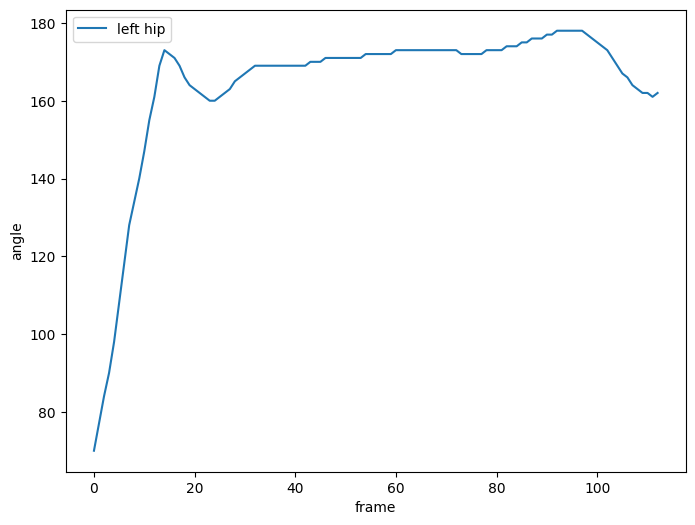

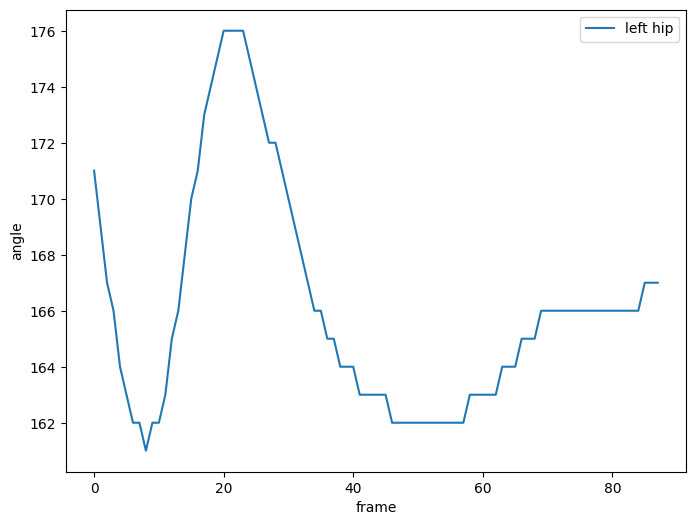

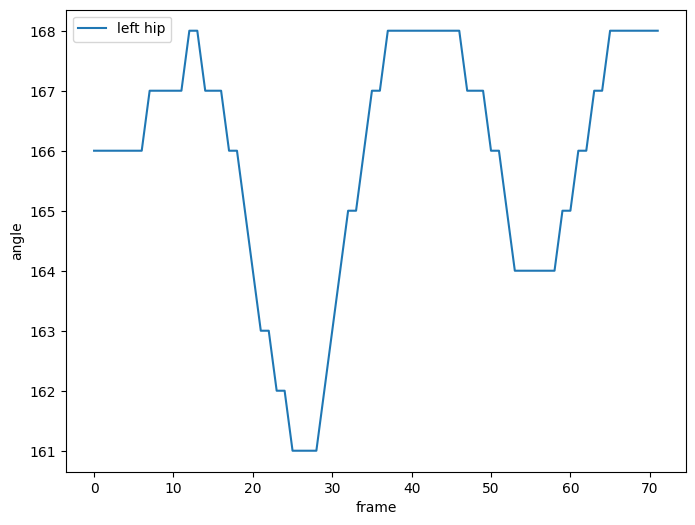

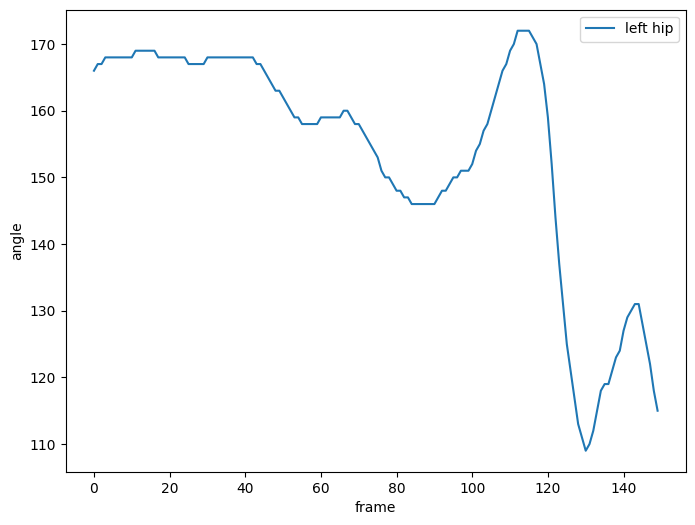

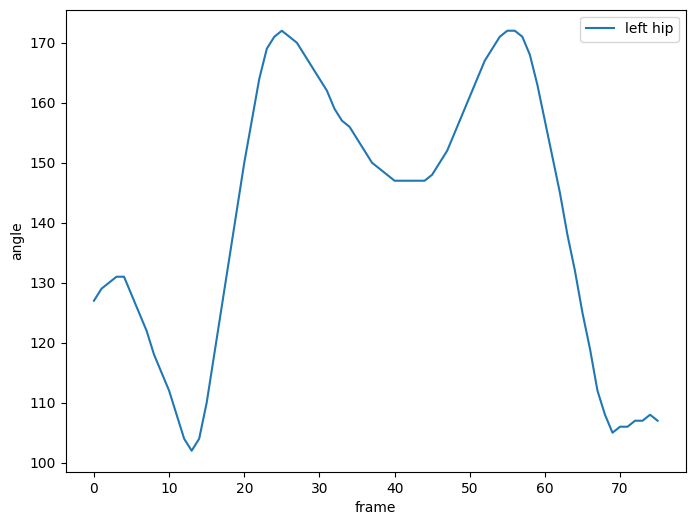

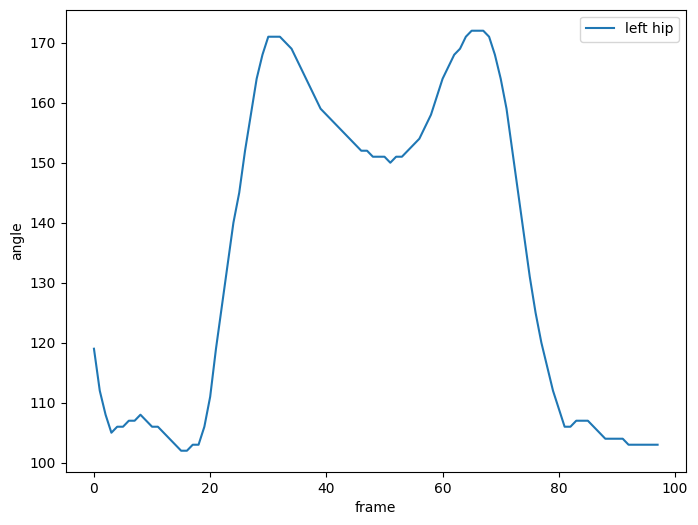

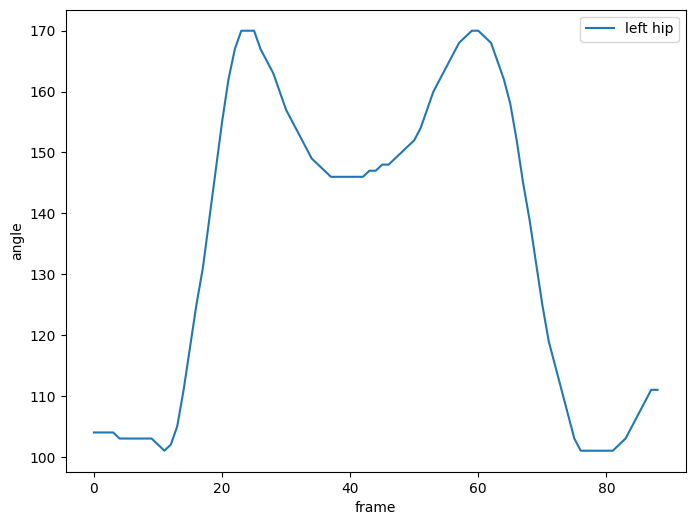

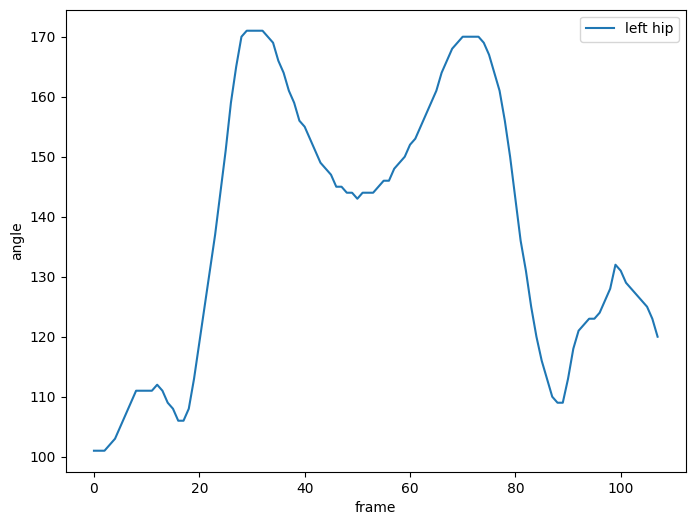

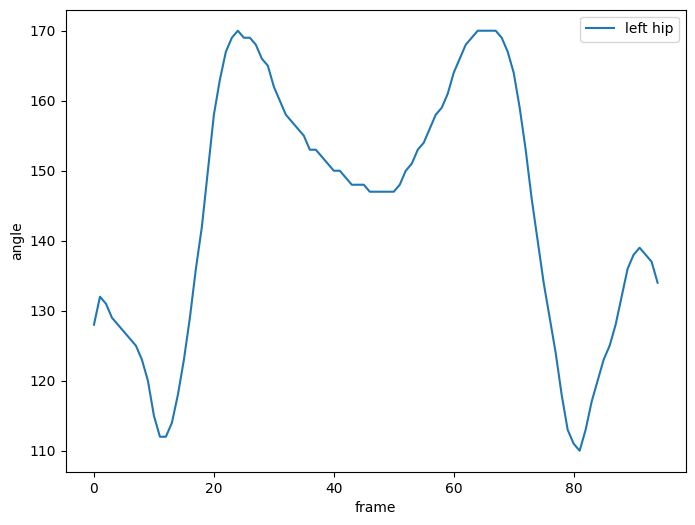

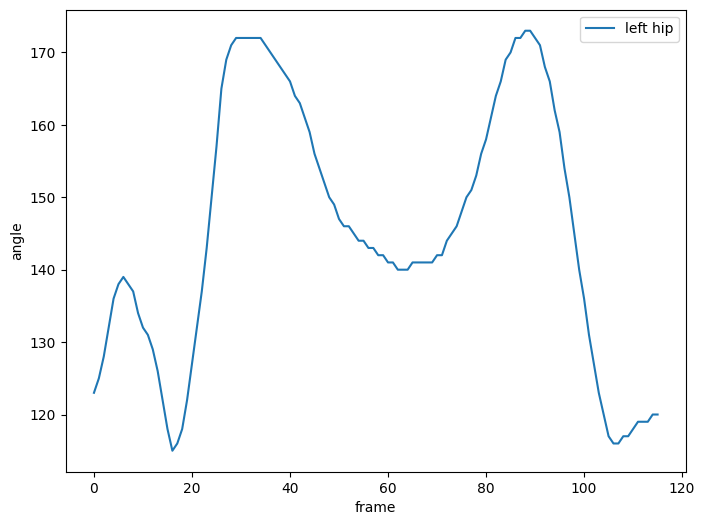

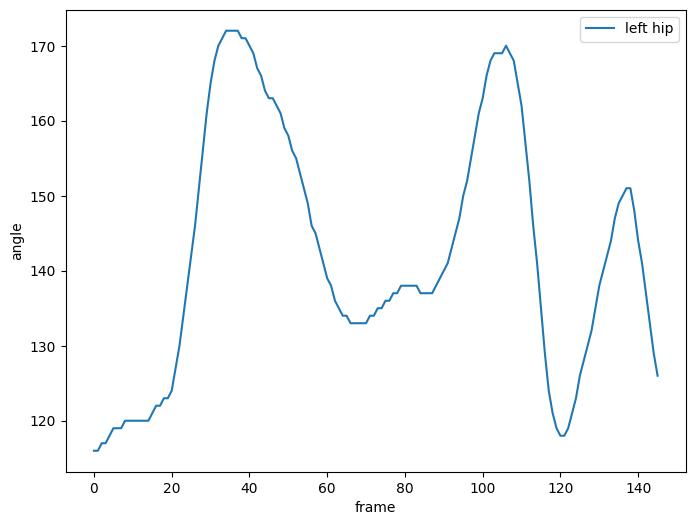

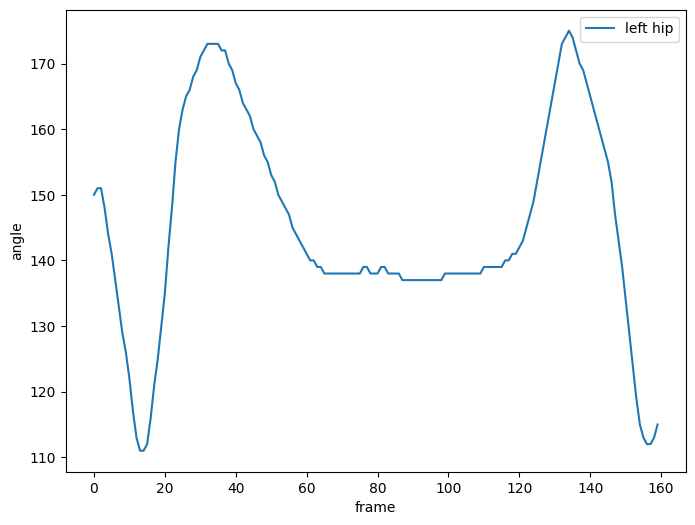

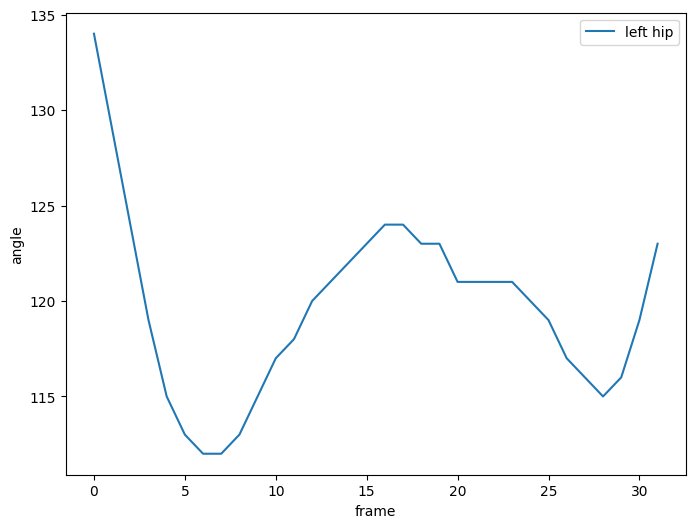

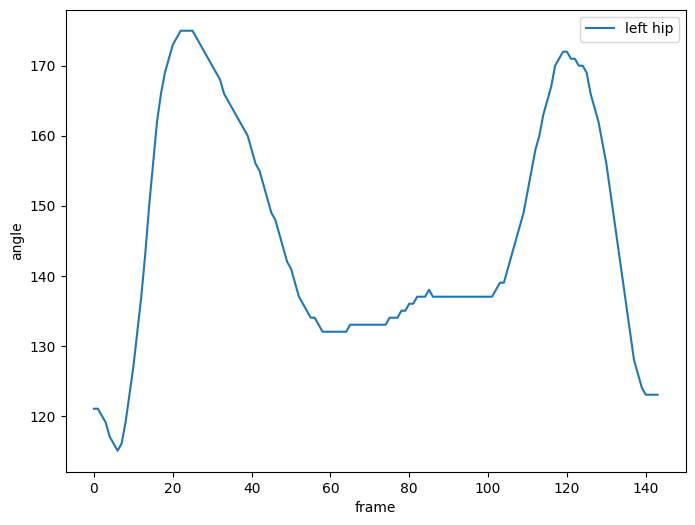

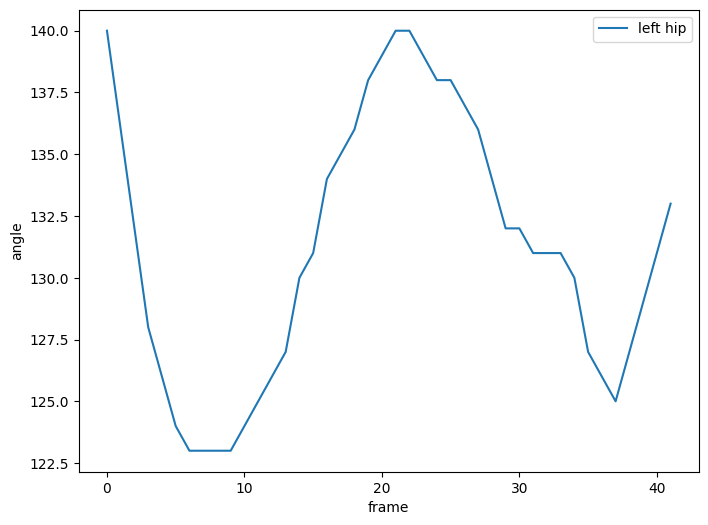

In [10]:
for rep in bench_split_reps:
    plt.figure(figsize=[8,6])
    plt.plot(rep['angles']['left shoulder'], label='left hip')
    plt.xlabel('frame')
    plt.ylabel('angle')
    plt.legend()
    plt.show()